# DSE Course 1, Session 6: Product Margin Case Study

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will look at how EDA and statistical analysis can allow us to ask "what if" questions around a manufacturing product portfolio

EDA objectives:

* product elimination impact on annual margin
* evaluating statistical significance of product margin

<br>

---


<a name='x.0'></a>

## 6.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 6.0.1 Import Packages

[back to top](#top)

In [15]:
# Pandas library for the pandas dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

<a name='x.0.2'></a>

### 6.0.2 Load Dataset

[back to top](#top)

For this session, we will use dummy datasets from sklearn.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wesleybeckner/'\
                 'ds_for_engineers/main/data/truffle_margin/margin_data.csv')
df['Width'] = df['Width'].apply(str)
df['Height'] = df['Height'].apply(str)
df.columns = df.columns.str.replace(' ', '_')

In [4]:
df.columns

Index(['Base_Cake', 'Truffle_Type', 'Primary_Flavor', 'Secondary_Flavor',
       'Color_Group', 'Width', 'Height', 'Net_Sales_Quantity_in_KG', 'EBITDA',
       'Product'],
      dtype='object')

In [9]:
descriptors = df.columns[:-3]

In [154]:
for col in df.columns[:-5]:
  print(col)
  print(df[col].unique())
  print()


Base_Cake
['Tiramisu' 'Sponge' 'Pound' 'Chiffon' 'Cheese' 'Butter']

Truffle_Type
['Chocolate Outer' 'Candy Outer' 'Jelly Filled']

Primary_Flavor
['Doughnut' 'Chocolate' 'Dill Pickle' 'Butter Milk' 'Amaretto' 'Coconut'
 'Blueberry' 'Chocolate Mint' 'Gingersnap' 'Coffee' 'Caramel Cream'
 'Cheesecake' 'Bavarian Cream' 'Black Licorice' 'Cherry Cola' 'Vanilla'
 'Lemon Custard' 'Sour' 'Mango' 'Irish Cream' 'Ginger Beer'
 'Grand Mariner' 'Ginger Ale' 'Fruit Punch' 'Watermelon' 'Plum'
 'Acai Berry' 'Pecan' 'Toasted Coconut' 'Orange Brandy' 'Wintergreen'
 'Creme de Menthe' 'Birch Beer' 'Apricot' 'Huckleberry' 'Bourbon'
 'Cherry Cream Spice' 'Lemon' 'Butter Toffee' 'Spice'
 'Raspberry Ginger Ale' 'Ginger Lime' 'Butter Pecan' 'Margarita'
 'Kettle Corn' 'Cream Soda' 'Pear' 'Lemon Bar' 'Horchata' 'Pink Lemonade'
 'Orange' 'Orange Pineapple\tP' 'Sassafras' 'Wild Cherry Cream']

Secondary_Flavor
['Egg Nog' 'Pear' 'Rock and Rye' 'Ginger Beer' 'Macadamia Nut'
 'Black Currant' 'Lemon' 'Apple' 'Tangeri

In [155]:
df.columns[-5:]

Index(['Width', 'Height', 'Net_Sales_Quantity_in_KG', 'EBITDA', 'Product'], dtype='object')

In [156]:
df['Height'][:10]

0     50
1     25
2    140
3     50
4     80
5     80
6     40
7    100
8     80
9     80
Name: Height, dtype: object

In [157]:
df['Product'][0]

'Tiramisu-Chocolate Outer-Doughnut-Egg Nog-Amethyst-340-50'

In [158]:
descriptors = df.columns[:-3]

## 6.1 Many Flavors of Statistical Tests

<p align="center">
<img src="https://luminousmen.com/media/descriptive-and-inferential-statistics.jpeg" width=400px></img>
<br>
<small> https://luminousmen.com/post/descriptive-and-inferential-statistics </small>
</p>

>Descriptive statistics describes data (for example, a chart or graph) and inferential statistics allows you to make predictions (“inferences”) from that data. With inferential statistics, you take data from samples and make generalizations about a population - [statshowto](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/inferential-statistics/#:~:text=Descriptive%20statistics%20describes%20data%20(for,make%20generalizations%20about%20a%20population.)

* **Moods Median Test**
* [Kruskal-Wallis Test](https://sixsigmastudyguide.com/kruskal-wallis-non-parametric-hypothesis-test/)
* T-Test
* Analysis of Variance (ANOVA)
  * One Way ANOVA
  * Two Way ANOVA
  * MANOVA
  * Factorial ANOVA

When do I use each of these? We will talk about this as we proceed through the examples. [This page](https://support.minitab.com/en-us/minitab/20/help-and-how-to/statistics/nonparametrics/supporting-topics/which-test-should-i-use/) from minitab has good rules of thumb on the subject.



### 6.1.1 What is Mood's Median?

**A special case of Pearon's Chi-Squared Test:** We create a table that counts the observations above and below the global median for two different groups. We then perform a *chi-squared test of significance* on this *contingency table* 

Null hypothesis: the Medians are all equal

The chi-square test statistic:

$x^2 = \sum{\frac{(O-E)^2}{E}}$

Where $O$ is the observed frequency and $E$ is the expected frequency.

**Let's take an example**, say we have three shifts with the following production rates:

In [10]:
random.seed(42)
def my_little_generator(mean, noise):
  return round(mean + noise * random.random() * random.choice([-1, 1]))

In [11]:
shift_one = [my_little_generator(16, 4) for i in range(10)]
shift_two = [my_little_generator(19, 4) for i in range(10)]

In [12]:
print(shift_one)
print(shift_two)

[13, 13, 15, 13, 14, 16, 15, 18, 17, 13]
[16, 22, 18, 23, 19, 19, 17, 16, 23, 19]


In [13]:
stat, p, m, table = scipy.stats.median_test(shift_one, shift_two, correction=False)

what is `median_test` returning?

In [14]:
print("The perasons chi-square test statistic: {:.2f}".format(stat))
print("p-value of the test: {:.3f}".format(p))
print("the grand median: {}".format(m))

The perasons chi-square test statistic: 7.20
p-value of the test: 0.007
the grand median: 16.5


Let's evaluate that test statistic ourselves by taking a look at the contingency table:

In [15]:
table

array([[2, 8],
       [8, 2]])

This is easier to make sense of if we order the shift times

In [16]:
shift_one.sort()
shift_one

[13, 13, 13, 13, 14, 15, 15, 16, 17, 18]

When we look at shift one, we see that 8 values are at or below the grand median.

In [17]:
shift_two.sort()
shift_two

[16, 16, 17, 18, 19, 19, 19, 22, 23, 23]

For shift two, only two are at or below the grand median.

Since the sample sizes are the same, the expected value for both groups is the same, 5 above and 5 below the grand median. The chi-square is then:

$X^2 = \frac{(2-5)^2}{5} + \frac{(8-5)^2}{5} + \frac{(8-5)^2}{5} + \frac{(2-5)^2}{5}$


In [18]:
(2-5)**2/5 + (8-5)**2/5 + (8-5)**2/5 + (2-5)**2/5

7.2

Our p-value, or the probability of observing the null-hypothsis, is under 0.05. We can conclude that these shift performances were drawn under seperate distributions.

For comparison, let's do this analysis again with shifts of equal performances

In [30]:
shift_three = [my_little_generator(16, 4) for i in range(10)]
shift_four = [my_little_generator(16, 4) for i in range(10)]
stat, p, m, table = scipy.stats.median_test(shift_three, shift_four,
                                            correction=False)
print("The perasons chi-square test statistic: {:.2f}".format(stat))
print("p-value of the test: {:.3f}".format(p))
print("the grand median: {}".format(m))

The perasons chi-square test statistic: 0.80
p-value of the test: 0.371
the grand median: 15.5


and the shift raw values:

In [32]:
shift_three.sort()
shift_four.sort()
print(shift_three)
print(shift_four)

[13, 13, 13, 14, 16, 17, 17, 18, 19, 19]
[13, 14, 14, 15, 15, 15, 17, 17, 19, 20]


In [33]:
table

array([[6, 4],
       [4, 6]])

### 6.1.2 When to Use Mood's?

**Mood's Median Test is highly flexible** but has the following assumptions:

* Considers only one categorical factor
* Response variable is continuous
* Data does not need to be normally distributed
  * But the distributions are similarly shaped
* Sample sizes can be unequal and small (less than 20 observations)

Other considerations:

* Not as powerful as Kruskal-Wallis Test but still useful for small sample sizes or when there are outliers

### 6.1.3 What is a T-test?

There are 1-sample and 2-sample T-tests 

_(note: we would use a 1-sample T-test just to determine if the sample mean is equal to a hypothesized population mean)_

Within 2-sample T-tests we have **_independent_** and **_dependent_** T-tests (do we believe the variables are correlated or not)

There two primary flavors of independent, two-sample T-tests:

* **_Equal variance_** (or pooled) T-test
  * `scipy.stats.ttest_ind(equal_var=True)`
* **_Unequal variance_** T-test
  * `scipy.stats.ttest_ind(equal_var=False)`

<br>

We also have dependent T-tests:
* Paired (or correlated) T-test
  * `scipy.stats.ttest_rel`

A full discussion on T-tests is outside the scope of this session, but we can refer to wikipedia for more information, including formulas on how each statistic is computed:
* [student's T-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples)

### 6.1.4 Enrichment: Practice with T-tests

[back to top](#top)

We'll assume our shifts are of **_equal variance_** and proceed with the appropriate **_independent two-sample_** T-test...

In [19]:
print(shift_one)
print(shift_two)

[13, 13, 13, 13, 14, 15, 15, 16, 17, 18]
[16, 16, 17, 18, 19, 19, 19, 22, 23, 23]


To calculate the T-test, we follow a slightly different statistical formula:

$T=\frac{\mu_1 - \mu_2}{s\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$

where $\mu$ are the means of the two groups, $n$ are the sample sizes and $s$ is the pooled standard deviation, also known as the cummulative variance (depending on if you square it or not):

$s= \sqrt{\frac{(n_1-1)\sigma_1^2 + (n_2-1)\sigma_2^2}{n_1 + n_2 - 2}}$

where $\sigma$ are the standard deviations. What you'll notice here is we are combining the two variances, we can only do this if we assume the variances are somewhat equal, this is known as the *equal variances* t-test.

In [20]:
mean_shift_one = np.mean(shift_one)
mean_shift_two = np.mean(shift_two)

print(mean_shift_one, mean_shift_two)

14.7 19.2


In [21]:
com_var = ((np.sum([(i - mean_shift_one)**2 for i in shift_one]) + 
            np.sum([(i - mean_shift_two)**2 for i in shift_two])) /
            (len(shift_one) + len(shift_two)-2))
print(com_var)

5.205555555555555


In [22]:
T = (np.abs(mean_shift_one - mean_shift_two) / (
     np.sqrt(com_var/len(shift_one) +
     com_var/len(shift_two))))

In [23]:
T

4.410257762597409

We see that this hand-computed result matches that of the `scipy` module:

In [24]:
scipy.stats.ttest_ind(shift_two, shift_one, equal_var=True)

Ttest_indResult(statistic=4.410257762597408, pvalue=0.00033771529900370443)

### 6.1.5 What are F-statistics and the F-test?

The F-statistic is simply a ratio of two variances, or the ratio of _mean squares_

_mean squares_ is the estimate of population variance that accounts for the degrees of freedom to comput that estimate. 

We will explore this in the context of ANOVA

### 6.1.6 What is Analysis of Variance? 

ANOVA uses the F-test to determine whether the variability between group means is larger than the variability within the groups. If that statistic is large enough, you can conclude that the means of the groups are not equal.

**The caveat is that ANOVA tells us whether there is a difference in means but it does not tell us where the difference is.** To find where the difference is between the groups, we have to conduct post-hoc tests.

There are two main types:
* One-way (one factor) and
* Two-way (two factor) where factor is an indipendent variable

#### ANOVA Hypotheses

* _Null hypothesis_: group means are equal
* _Alternative hypothesis_: at least one group mean is different form the other groups

### ANOVA Assumptions

* Residuals (experimental error) are normally distributed (test with Shapiro-Wilk)
* Homogeneity of variances (varainces are equal between groups) (test with Bartlett's)
* Observations are sampled independently from each other
* _Note: ANOVA assumptions can be checked using test statistics (e.g. Shapiro-Wilk, Bartlett’s, Levene’s test) and the visual approaches such as residual plots (e.g. QQ-plots) and histograms but they are beyond the scope of this session._

### Steps for ANOVA

* Check sample sizes: equal observations must be in each group
* Calculate Mean Square for each group (MS)
* Calculate Mean Square Error for each group (MSE)
* Calculate F value (MS/MSE)

<br>

This might be easier to see in a table:

<br>

| Source of Variation         | degree of freedom (Df) | Sum of squares (SS) | Mean square (MS)   | F value     |
|-----------------------------|------------------------|---------------------|--------------------|-------------|
| Between Groups             | Df_b = p-1             | SS_B                | MS_B = SS_B / Df_B | MS_B / MS_E |
| Within Groups | Df_E = p(r-1)          | SS_E                | MS_E = SS_E / Df_E |             |
| total                       | Df_T = pr-1            | SS_T           |                    |             |

Where

$$ SS_B = \sum_{i}{p_i (\bar{y}_i-\bar{y})^2} $$
$$ SS_E = \sum_{ik}{(\bar{y}_{ik}-\bar{y}_i)^2} $$
$$ SS_T = SS_B + SS_E $$

Let's go  back to our shift data to take an example:

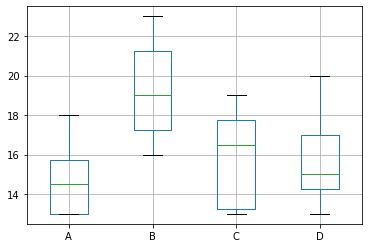

In [36]:
shifts = pd.DataFrame([shift_one, shift_two, shift_three, shift_four]).T
shifts.columns = ['A', 'B', 'C', 'D']
shifts.boxplot()

We haven't played with seaborn much so don't worry too much about this, but this is another great way to view boxplot data:

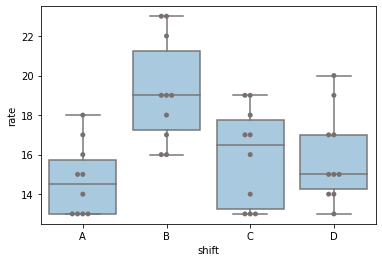

In [57]:
shift_melt = pd.melt(shifts.reset_index(), id_vars=['index'], 
                     value_vars=['A', 'B', 'C', 'D'])
shift_melt.columns = ['index', 'shift', 'rate']
ax = sns.boxplot(x='shift', y='rate', data=shift_melt, color='#A0cbe8')
ax = sns.swarmplot(x="shift", y="rate", data=shift_melt, color='#79706e')

In [66]:
fvalue, pvalue = stats.f_oneway(shifts['A'], 
                                shifts['B'],
                                shifts['C'],
                                shifts['D'])
print(fvalue, pvalue)

6.891560102301792 0.0008732875285089983


We can get this in the format of the table we saw above:

In [67]:
# get ANOVA table 
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('rate ~ C(shift)', data=shift_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(shift),112.275,3.0,6.89156,0.000873
Residual,195.500,36.0,NaN,NaN


The **_Shapiro-Wilk_** test can be used to check the _normal distribution of residuals_. Null hypothesis: data is drawn from normal distribution.

In [74]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9346632957458496 0.022929303348064423


We can use **_Bartlett’s_** test to check the _Homogeneity of variances_. Null hypothesis: samples from populations have equal variances.

In [77]:
w, pvalue = stats.bartlett(shifts['A'], 
                           shifts['B'], 
                           shifts['C'], 
                           shifts['D'])
print(w, pvalue)

1.2592510066654592 0.7388313051459896


#### 6.1.6.1 ANOVA Interpretation

The _p_ value form ANOVA analysis is significant (_p_ < 0.005) and we can conclude there are significant difference between the shifts. But we do not know which shift(s) are different. For this we need to perform a post hoc test. There are a multitude of these that are beyond the scope of this discussion ([Turkey-kramer](https://www.real-statistics.com/one-way-analysis-of-variance-anova/unplanned-comparisons/tukey-kramer-test/) is one such test) 

### 6.1.7 Putting it all together

In summary, there are many statistical tests at our disposal when performing inferential statistical analysis. In times like these, a simple decision tree can be extraordinarily useful!

<img src="https://cdn.scribbr.com/wp-content/uploads//2020/01/flowchart-for-choosing-a-statistical-test.png" width=800px></img>

<small>source: [scribbr](https://www.scribbr.com/statistics/statistical-tests/)</small>

## 6.2 Evaluate statistical significance of product margin: a snake in the garden

### 6.2.1 Mood's Median on product descriptors

The first issue we run into with moods is... what? 

We can only perform moods on two groups at a time. How can we get around this?

Let's take a look at the category with the fewest descriptors. If we remember, this was the Truffle Types.

In [13]:
df['Truffle_Type'].unique()

array(['Chocolate Outer', 'Candy Outer', 'Jelly Filled'], dtype=object)

In [16]:
col = 'Truffle_Type'
moodsdf = pd.DataFrame()
for truff in df[col].unique():
  print(truff)
  # for each 
  group = df.loc[df[col] == truff]['EBITDA']
  pop = df.loc[~(df[col] == truff)]['EBITDA']
  stat, p, m, table = scipy.stats.median_test(group, pop)
  median = np.median(group)
  mean = np.mean(group)
  size = len(group)
  print("Welch's T-Test for Unequal Variances")
  print(scipy.stats.ttest_ind(group, pop, equal_var=False))
  welchp = scipy.stats.ttest_ind(group, pop, equal_var=False).pvalue
  print()
  moodsdf = pd.concat([moodsdf, 
                            pd.DataFrame([truff, 
                                          stat, p, m, mean, median, size,
                                          welchp, table]).T])
moodsdf.columns = [col, 'pearsons_chi_square', 'p_value', 
              'grand_median', 'group_mean', 'group_median', 'size', 'welch p',
              'table']

Chocolate Outer
Welch's T-Test for Unequal Variances
Ttest_indResult(statistic=-3.446568103233787, pvalue=0.0005776732507347493)

Candy Outer
Welch's T-Test for Unequal Variances
Ttest_indResult(statistic=4.3263328244214, pvalue=1.5786146670916492e-05)

Jelly Filled
Welch's T-Test for Unequal Variances
Ttest_indResult(statistic=-2.8729818741341635, pvalue=0.010482348548218801)



### Question 1: Moods Results on Truffle Type

> What do we notice about the resultant table?

* **_p-values_** Most are quite small (really low probability of achieving these table results under a single distribution)
* group sizes: our Jelly Filled group is relatively small

In [17]:
moodsdf.sort_values('p_value')

,Truffle_Type,pearsons_chi_square,p_value,grand_median,group_mean,group_median,size,welch p,table
0,Candy Outer,203.678,3.28975e-46,33.745,5483.36,1143.26,818,1.57861e-05,"[[577, 676], [241, 1012]]"
0,Chocolate Outer,182.658,1.27351e-41,33.745,1859.89,-209.7,1670,0.000577673,"[[675, 578], [995, 258]]"
0,Jelly Filled,12.5904,0.000387726,33.745,-18454.5,-7756.69,18,0.0104823,"[[1, 1252], [17, 1236]]"


We can go ahead and repeat this analysis for all of our product categories:

In [22]:
moodsdf = pd.DataFrame()
for col in df.columns[:5]:
  # col = 'Truffle_Type'
  
  for truff in df[col].unique():
    # print(truff)
    # for each 
    group = df.loc[df[col] == truff]['EBITDA']
    pop = df.loc[~(df[col] == truff)]['EBITDA']
    stat, p, m, table = scipy.stats.median_test(group, pop)
    median = np.median(group)
    mean = np.mean(group)
    size = len(group)
    # print("Welch's T-Test for Unequal Variances")
    # print(scipy.stats.ttest_ind(group, pop, equal_var=False))
    welchp = scipy.stats.ttest_ind(group, pop, equal_var=False).pvalue
    # print()
    moodsdf = pd.concat([moodsdf, 
                              pd.DataFrame([col, truff, 
                                            stat, p, m, mean, median, size,
                                            welchp, table]).T])
moodsdf.columns = ['descriptor', 'group', 'pearsons_chi_square', 'p_value', 
                'grand_median', 'group_mean', 'group_median', 'size', 'welch p',
                'table']

In [23]:
moodsdf = moodsdf.loc[(moodsdf['welch p'] < 0.005) &
            (moodsdf['p_value'] < 0.005)].sort_values('group_median')

In [24]:
moodsdf

,descriptor,group,pearsons_chi_square,p_value,grand_median,group_mean,group_median,size,welch p,table
0,Primary_Flavor,Creme de Menthe,17.5524,2.79498e-05,33.745,-9320.5,-5945.59,23,1.80827e-05,"[[1, 1252], [22, 1231]]"
0,Secondary_Flavor,Papaya,91.1389,1.33935e-21,33.745,-3790.46,-1683.78,115,6.13501e-15,"[[7, 1246], [108, 1145]]"
0,Primary_Flavor,Orange Pineapple\tP,91.1389,1.33935e-21,33.745,-3790.46,-1683.78,115,6.13501e-15,"[[7, 1246], [108, 1145]]"
0,Primary_Flavor,Cream Soda,111.332,5.00577e-26,33.745,-4890.25,-1580.45,157,6.48382e-13,"[[14, 1239], [143, 1110]]"
0,Secondary_Flavor,Peppermint,111.332,5.00577e-26,33.745,-4890.25,-1580.45,157,6.48382e-13,"[[14, 1239], [143, 1110]]"
0,Primary_Flavor,Lemon Bar,17.228,3.31518e-05,33.745,-5155.42,-1434.09,69,7.78756e-06,"[[17, 1236], [52, 1201]]"
0,Secondary_Flavor,Wild Cherry Cream,17.228,3.31518e-05,33.745,-5155.42,-1434.09,69,7.78756e-06,"[[17, 1236], [52, 1201]]"
0,Secondary_Flavor,Dill Pickle,56.5958,5.3526e-14,33.745,-6271.44,-1314.84,82,1.57725e-05,"[[7, 1246], [75, 1178]]"
0,Primary_Flavor,Horchata,56.5958,5.3526e-14,33.745,-6271.44,-1314.84,82,1.57725e-05,"[[7, 1246], [75, 1178]]"
0,Secondary_Flavor,Apricot,13.1453,0.000288234,33.745,-985.045,-1026.43,15,2.06716e-13,"[[0, 1253], [15, 1238]]"


### 6.2.2 Broad Analysis of Categories: ANOVA



Recall our "melted" shift data. It will be useful to think of getting our Truffle data in this format:

In [86]:
shift_melt.head()

,index,shift,rate
0,0,A,13
1,1,A,13
2,2,A,13
3,3,A,13
4,4,A,14


In [93]:
df.columns

Index(['Base_Cake', 'Truffle_Type', 'Primary_Flavor', 'Secondary_Flavor',
       'Color_Group', 'Width', 'Height', 'Net_Sales_Quantity_in_KG', 'EBITDA',
       'Product'],
      dtype='object')

In [123]:
# get ANOVA table 
# Ordinary Least Squares (OLS) model
model = ols('EBITDA ~ C(Truffle_Type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(Truffle_Type),1.547400e+10,2.0,12.95365,0.000003
Residual,1.495000e+12,2503.0,NaN,NaN


Recall the **_Shapiro-Wilk_** test can be used to check the _normal distribution of residuals_. Null hypothesis: data is drawn from normal distribution.

In [124]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.3718891143798828 0.0


And the **_Bartlett’s_** test to check the _Homogeneity of variances_. Null hypothesis: samples from populations have equal variances.

In [125]:
gb = df.groupby('Truffle_Type')['EBITDA']

In [126]:
w, pvalue = stats.bartlett(*[gb.get_group(x) for x in gb.groups])
print(w, pvalue)

234.53964560580766 1.1758801603181973e-51


Wow it looks like our data is not drawn from a normal distribution! Let's check this for other categories...

We can wrap these in a for loop:

In [165]:
for col in df.columns[:5]:
  model = ols('EBITDA ~ C({})'.format(col), data=df).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  display(anova_table)
  w, pvalue = stats.shapiro(model.resid)
  print(w, pvalue)
  gb = df.groupby(col)['EBITDA']
  w, pvalue = stats.bartlett(*[gb.get_group(x) for x in gb.groups])
  print(w, pvalue)
  print()

,sum_sq,df,F,PR(>F)
C(Base_Cake),4.391438e+10,5.0,14.971903,1.651883e-14
Residual,1.466560e+12,2500.0,NaN,NaN


0.40582507848739624 0.0
1389.6799459243055 2.3711669518280586e-298



,sum_sq,df,F,PR(>F)
C(Truffle_Type),1.547400e+10,2.0,12.95365,0.000003
Residual,1.495000e+12,2503.0,NaN,NaN


0.3718891143798828 0.0
234.53964560580766 1.1758801603181973e-51



,sum_sq,df,F,PR(>F)
C(Primary_Flavor),1.735442e+11,53.0,6.005456,1.283368e-36
Residual,1.336930e+12,2452.0,NaN,NaN


0.4298985004425049 0.0
3160.799893765378 0.0



,sum_sq,df,F,PR(>F)
C(Secondary_Flavor),9.578840e+10,30.0,5.586077,3.089258e-20
Residual,1.414686e+12,2475.0,NaN,NaN


0.4123855233192444 0.0
2253.4814993527275 0.0



,sum_sq,df,F,PR(>F)
C(Color_Group),4.556430e+10,12.0,6.46182,1.899953e-11
Residual,1.464910e+12,2493.0,NaN,NaN


0.4083861708641052 0.0
1192.2487191197968 8.084162457816312e-248



### 6.2.3 Visual Analysis of Residuals: QQ-Plots

This can be distressing and is often why we want visual methods to see what is going on with our data!

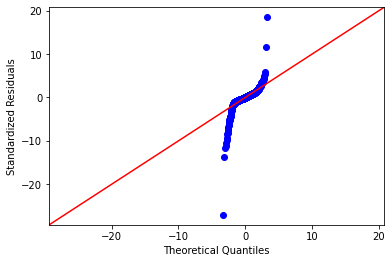

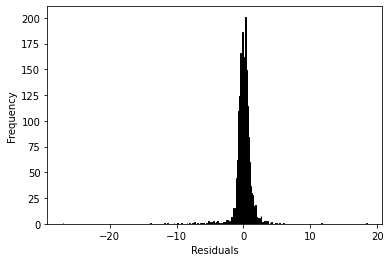

In [145]:
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(model.resid, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(model.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

We see that a lot of our data is swayed by extremely high and low values, so what can we conclude? 

> You need the right test statistic for the right job, in this case, we are littered with unequal variance in our groupings so we use the moods median and welch (unequal variance t-test) to make conclusions about our data


## 6.3 Sneak Peak Course 4: Visualizing the Data

In [194]:
!pip install jupyter-dash

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 1.0MB 11.3MB/s 
     |████████████████████████████████| 3.5MB 28.3MB/s 
     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 1.8MB 26.2MB/s 
     |████████████████████████████████| 358kB 59.0MB/s 
  Created wheel for dash: filename=dash-1.20.0-cp37-none-any.whl size=85834 sha256=9f374d2cee0dda4eab700fc61702e3fa569735743e792af30cae61da3c68cb0b
  Stored in directory: /root/.cache/pip/wheels/e6/33/41/ce361d0d1da277d2350f815b10f2ab1e331592d93ef2b07e29
  Created wheel for dash-renderer: filename=dash_renderer-1.9.1-cp37-none-any.whl size=1014875 sha256=75b3e79a84ddf54487761aa20d95f93f2282c5a0919eb8ae5615d6bcd787fb91
  Stored in directory: /root/.cache/pip/wheels/03/a9/c5/dd5815c601b0ede164c223ffd7bafebde716ca57de06ef8aec
  Created wheel for dash-core-components: filename=dash_core_components-1.16.0-cp37-none-any.whl size=3540993 sha256=9861e54ed01603b0559d5b

In [195]:
!pip install dash_daq

     |████████████████████████████████| 645kB 10.7MB/s 
  Created wheel for dash-daq: filename=dash_daq-0.5.0-cp37-none-any.whl size=669704 sha256=c36542a314bd024881c47841a8f64488ec1d4f0b50b72d821ced9c5532434d26
  Stored in directory: /root/.cache/pip/wheels/1c/9c/f7/84731716eaa9fc952cdbdd1f87df3ca9b8805c317c609efcd6
Successfully built dash-daq


In [196]:
!pip install --ignore-installed --upgrade plotly==4.5.0

     |████████████████████████████████| 7.1MB 7.3MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11430 sha256=d1bf231e2d399f37c607662e1edb29f7bc9c9b5b045ec5eaafe09f894f180193
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_daq as daq
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

In [6]:
import plotly

%load_ext autoreload
%autoreload 2
print(plotly.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4.5.0


In [7]:
def make_violin_plot(sort='Worst', select=[0,5], descriptors=None):

    if sort == 'Best':
        local_df = moodsdf.sort_values('group_median', ascending=False)
        local_df = local_df.reset_index(drop=True)
    else:
        local_df = moodsdf
    if descriptors != None:
        local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
    fig = go.Figure()
    for index in range(select[0],select[1]):
        x = df.loc[(df[local_df.iloc[index]['descriptor']] == \
            local_df.iloc[index]['group'])]['EBITDA']
        y = local_df.iloc[index]['descriptor'] + ': ' + df.loc[(df[local_df\
            .iloc[index]['descriptor']] == local_df.iloc[index]['group'])]\
            [local_df.iloc[index]['descriptor']]
        name = '€ {:.0f}'.format(x.median())
        fig.add_trace(go.Violin(x=y,
                                y=x,
                                name=name,
                                box_visible=True,
                                meanline_visible=True))
    fig.update_layout({
                "plot_bgcolor": "#FFFFFF",
                "paper_bgcolor": "#FFFFFF",
                "title": 'EBITDA by Product Descriptor (Median in Legend)',
                "yaxis.title": "EBITDA (€)",
                "height": 325,
                "font": dict(
                            size=10),
                "margin": dict(
                       l=0,
                       r=0,
                       b=0,
                       t=30,
                       pad=4
   ),
                })

    return fig

def make_sunburst_plot(clickData=None, toAdd=None, col=None, val=None):
    if clickData != None:
        col = clickData["points"][0]['x'].split(": ")[0]
        val = clickData["points"][0]['x'].split(": ")[1]
    elif col == None:
        col = moodsdf.iloc[-1]['descriptor']
        val = moodsdf.iloc[-1]['group']

    desc = list(descriptors[:-2])
    if col in desc:
        desc.remove(col)
    if toAdd != None:
        for item in toAdd:
            desc.append(item)
    test = df.loc[df[col] == val]
    fig = px.sunburst(test, path=desc[:], color='EBITDA', title='{}: {}'.format(
        col, val),
        color_continuous_scale=px.colors.sequential.Viridis
                     )
    fig.update_layout({
                "plot_bgcolor": "#FFFFFF",
                "title": '(Select in Violin) {}: {}'.format(col,val),
                "paper_bgcolor": "#FFFFFF",
                "height": 325,
                "font": dict(
                    size=10),
                "margin": dict(
                       l=0,
                       r=0,
                       b=0,
                       t=30,
                       pad=4
   ),
                })
    return fig

def make_ebit_plot(df, select=None, sort='Worst', descriptors=None):
    families = df[df.columns[0]].unique()
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3',\
              '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
    colors_cycle = cycle(colors)
    
    color_dic = {'{}'.format(i): '{}'.format(j) for i, j  in zip(families,
                                                                 colors)}
    
    fig = go.Figure()


    if select == None:
        for data in px.scatter(
                df,
                x='Product',
                y='EBITDA',
                color=df.columns[0],
                color_discrete_map=color_dic,
                opacity=1).data:
            fig.add_trace(
                data
            )

    elif select != None:
        color_dic = {'{}'.format(i): '{}'.format(j) for i, j  in zip(select,
                                                                     colors)}
        for data in px.scatter(
                df,
                x='Product',
                y='EBITDA',
                color=df.columns[0],

                color_discrete_map=color_dic,
                opacity=0.09).data:
            fig.add_trace(
                data
            )

        if sort == 'Best':
            local_df = moodsdf.sort_values('group_median', ascending=False)
        elif sort == 'Worst':
            local_df = moodsdf
            


        new_df = pd.DataFrame()
        if descriptors != None:
            local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
        for index in select:
            x = df.loc[(df[local_df.iloc[index]\
                ['descriptor']] == local_df.iloc[index]['group'])]
            x['color'] = next(colors_cycle) # for line shapes
            new_df = pd.concat([new_df, x])
            new_df = new_df.reset_index(drop=True)
        shapes=[]

        for index, i in enumerate(new_df['Product']):
            shapes.append({'type': 'line',
                           'xref': 'x',
                           'yref': 'y',
                           'x0': i,
                           'y0': -4e5,
                           'x1': i,
                           'y1': 4e5,
                           'line':dict(
                               dash="dot",
                               color=new_df['color'][index],)})
        fig.update_layout(shapes=shapes)
    fig.update_layout({
            "plot_bgcolor": "#FFFFFF",
            "paper_bgcolor": "#FFFFFF",
            "title": 'Rank Order EBITDA by {}'.format(df.columns[0]),
            "yaxis.title": "EBITDA (€)",
            "height": 325,
            "font": dict(
                        size=10),
            "xaxis": dict(
                showticklabels=False
            ),
            "margin": dict(
                   l=0,
                   r=0,
                   b=0,
                   t=30,
                   pad=4
),
            "xaxis.tickfont.size": 8,
            })
    return fig

In [25]:
# Build App
external_stylesheets = ['../assets/styles.css', '../assets/s1.css', 'https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    html.Div([
        html.Div([
            html.P('Descriptors'),
            dcc.Dropdown(id='descriptor_dropdown',
                         options=[{'label': i, 'value': i} for i in descriptors],
                         value=descriptors,
                         multi=True,
                         className="dcc_control"),
            html.P('Number of Descriptors:', id='descriptor-number'),
            dcc.RangeSlider(
                        id='select',
                        min=0,
                        max=moodsdf.shape[0],
                        step=1,
                        value=[0,10]),
            html.P('Sort by:'),
            dcc.RadioItems(
                        id='sort',
                        options=[{'label': i, 'value': j} for i, j in \
                                [['Low EBITDA', 'Worst'],
                                ['High EBITDA', 'Best']]],
                        value='Best',
                        labelStyle={'display': 'inline-block'},
                        style={"margin-bottom": "10px"},),
            html.P('Toggle view Violin/Descriptor Data'),
            daq.BooleanSwitch(
                  id='daq-violin',
                  on=False,
                  style={"margin-bottom": "10px", "margin-left": "0px",
                  'display': 'inline-block'}),
            
        ],  
        className='mini_container',
        id='descriptorBlock',
        style={'width': '32%', 'display': 'inline-block'}
        ),     
        html.Div([
            dcc.Graph(
                        id='ebit_plot',
                        figure=make_ebit_plot(df)),
        ], 
        className='mini_container',
        style={'width': '65%', 'float': 'right', 'display': 'inline-block'},
        id='ebit-family-block'
        ),

    ], className='row container-display',
       
    ),

    html.Div([
        html.Div([
            dcc.Graph(
                id='violin_plot',
                figure=make_violin_plot()),
        ], 
        className='mini_container',
        style={'width': '65%', 'display': 'inline-block'},
        id='violin',
        ),
        html.Div([
            dcc.Dropdown(id='length_width_dropdown',
                        options=[{'label': 'Height', 'value': 'Height'},
                                 {'label': 'Width', 'value': 'Width'}],
                        value=['Width'],
                        multi=True,
                        placeholder="Include in sunburst chart...",
                        className="dcc_control"),
            dcc.Graph(
                        id='sunburst_plot',
                        figure=make_sunburst_plot()
            ),
            ], 
            className='mini_container',
            style={'width': '32%', 'display': 'inline-block'},
            id='sunburst',
                ),
            ], className='row container-display',
               style={'margin-bottom': '50px'},
            ),
], className='pretty container'
)

In [26]:
@app.callback(
    Output('sunburst_plot', 'figure'),
    [Input('violin_plot', 'clickData'),
     Input('length_width_dropdown', 'value'),
     Input('sort', 'value'),
     Input('select', 'value'),
     Input('descriptor_dropdown', 'value')])
def display_sunburst_plot(clickData, toAdd, sort, select, descriptors):
    if sort == 'Best':
        local_df = moodsdf.sort_values('group_median', ascending=False)
        local_df = local_df.reset_index(drop=True)
    else:
        local_df = moodsdf
    if descriptors != None:
        local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
    local_df = local_df.reset_index(drop=True)
    col = local_df['descriptor'][select[0]]
    val = local_df['group'][select[0]]
    return make_sunburst_plot(clickData, toAdd, col, val)

@app.callback(
    [Output('select', 'max'),
    Output('select', 'value')],
    [Input('descriptor_dropdown', 'value')]
)
def update_descriptor_choices(descriptors):
    max_value = moodsdf.loc[moodsdf['descriptor'].isin(descriptors)].shape[0]
    value = min(5, max_value)
    return max_value, [0, value]

@app.callback(
    Output('descriptor-number', 'children'),
    [Input('select', 'value')]
)
def display_descriptor_number(select):
    return "Number of Descriptors: {}".format(select[1]-select[0])

@app.callback(
    Output('violin_plot', 'figure'),
    [Input('sort', 'value'),
    Input('select', 'value'),
    Input('descriptor_dropdown', 'value')]
)
def display_violin_plot(sort, select, descriptors):
    return make_violin_plot(sort, select, descriptors)

@app.callback(
    Output('ebit_plot', 'figure'),
    [Input('sort', 'value'),
    Input('select', 'value'),
    Input('descriptor_dropdown', 'value'),
    Input('daq-violin', 'on')]
)
def display_ebit_plot(sort, select, descriptors, switch):
    if switch == True:
        select = list(np.arange(select[0],select[1]))
        return make_ebit_plot(df, select, sort=sort, descriptors=descriptors)
    else:
        return make_ebit_plot(df)

In [27]:
app.run_server(mode='external', port='8881')

Dash app running on:


<IPython.core.display.Javascript object>

# References

* [Renesh Bedre ANOVA](https://www.reneshbedre.com/blog/anova.html)
* [Minitab ANOVA](https://blog.minitab.com/en/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test)
* [Analytics Vidhya ANOVA](https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/)
* [Renesh Bedre Hypothesis Testing](https://www.reneshbedre.com/blog/hypothesis-testing.html)
* [Real Statistics Turkey-kramer](https://www.real-statistics.com/one-way-analysis-of-variance-anova/unplanned-comparisons/tukey-kramer-test/)